<a href="https://colab.research.google.com/github/AliBenovaa/IANNwTF_Group24/blob/main/homework09_group24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
#from tensorflow.keras import layers
import time
import urllib
from IPython import display
import datetime
import numpy as np
import tqdm 
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
def download_data():
    category = 'candle'
    if not os.path.isfile(f"npy_files/{category}.npy"):
        print("Start downloading data...")
        #Download files
        # categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
        # print(categories[:10])

        # Creates a folder to download the original drawings into.
        # We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

        if not os.path.isdir('npy_files'):
            os.mkdir('npy_files')

        url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'
        urllib.request.urlretrieve(url, f'npy_files/{category}.npy')
        print("Finished downloading data!")
    else:
        print("Data was already downloaded. Proceeding...")

def prepare_dataset(dataset):
    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    dataset = dataset.cache()
    # convert data from uint8 to float32
    dataset = dataset.map(lambda vector: tf.cast(vector, tf.float32))
    # sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda vector: (vector / 128.) - 1.)
    # reshape tensor
    dataset = dataset.map(lambda vector: tf.reshape(vector, (28, 28)))
    # expand dim
    dataset = dataset.map(lambda vector: tf.expand_dims(vector, axis=-1))
    # shuffle, batch, prefetch
    dataset = dataset.shuffle(50000)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(32)
    return dataset


In [ ]:
BATCH_SIZE = 256
NOISE_INPUT_DIM = 100
EPOCHS = 10

In [ ]:
class Generator(tf.keras.Model):
    """
    This class represents Generator of the GAN
    """

    def __init__(self, input_dim=100):
        super(Generator, self).__init__()

        # self.net_layers = []
        # # initial Dense-Layer
        # self.net_layers.append(tf.keras.layers.Dense(7*7*128, use_bias=True, input_shape=(input_dim,)))
        # self.net_layers.append(tf.keras.layers.BatchNormalization())
        # self.net_layers.append(tf.keras.layers.LeakyReLU())
        # self.net_layers.append(tf.keras.layers.Reshape((7,7,128)))
        # # use upsampling
        # self.net_layers.append(tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=True)) # hints state that Conv2DTrans might work better with even kernel-size
        # self.net_layers.append(tf.keras.layers.BatchNormalization())
        # self.net_layers.append(tf.keras.layers.LeakyReLU())
        # self.net_layers.append(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=True))
        # self.net_layers.append(tf.keras.layers.BatchNormalization())
        # self.net_layers.append(tf.keras.layers.LeakyReLU())
        # self.net_layers.append(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=True)) # hints state that Conv2DTrans might work better with even kernel-size
        # self.net_layers.append(tf.keras.layers.BatchNormalization())
        # self.net_layers.append(tf.keras.layers.LeakyReLU())
        # # last convlayer with tanh
        # self.net_layers.append(tf.keras.layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=True, activation='tanh'))
        
        self.net_layers = []
        # initial Dense-Layer
        self.net_layers.append(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(input_dim,)))
        self.net_layers.append(tf.keras.layers.BatchNormalization())
        self.net_layers.append(tf.keras.layers.LeakyReLU())
        self.net_layers.append(tf.keras.layers.Reshape((7,7,256)))
        # use upsampling
        self.net_layers.append(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        self.net_layers.append(tf.keras.layers.BatchNormalization())
        self.net_layers.append(tf.keras.layers.LeakyReLU())
        self.net_layers.append(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        self.net_layers.append(tf.keras.layers.BatchNormalization())
        self.net_layers.append(tf.keras.layers.LeakyReLU())
        # last convlayer with tanh
        self.net_layers.append(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        # tf.keras.metrics.BinaryAccuracy, 
                        ]
    @tf.function
    def call(self, inputs, training=False):
        """
        calculates the output of the network for
        the given input
        :param inputs: the input tensor of the network
        :training: boolean for training
        :return: output of the network
        """
        for layer in self.net_layers:
            inputs = layer(inputs, training=training)
        return inputs

    def reset_metrics(self):    
        for metric in self.metrics_list:
            metric.reset_states()

    @tf.function
    def train_step(self, noise, discriminator):
        with tf.GradientTape() as tape:
            generated_images = self(noise, training=True)
            fake_output = discriminator(generated_images, training=False)
            fake_targets = tf.ones_like(fake_output)

            total_loss = self.loss(fake_targets, fake_output)
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update loss metric
        self.metrics_list[0].update_state(total_loss)
        
        # for all metrics except loss, update states (accuracy etc.)
        for metric in self.metrics_list[1:]:
            metric.update_state(y_true=fake_targets, y_pred=fake_output)

        # Return a dictionary mapping metric names to current value
        return ({m.name: m.result() for m in self.metrics_list}, generated_images)

    @tf.function
    def test_step(self, noise, discriminator):

        generated_images = self(noise, training=False)
        fake_output = discriminator(generated_images, training=False)
        fake_targets = tf.ones_like(fake_output)

        total_loss = self.loss(fake_targets, fake_output)
        
        self.metrics_list[0].update_state(total_loss)
        
        for metric in self.metrics_list[1:]:
            metric.update_state(y_true=fake_targets, y_pred=fake_output)

        return ({m.name: m.result() for m in self.metrics_list}, generated_images)

In [ ]:
class Discriminator(tf.keras.Model):
    """
    This class represents Discriminator of the GAN
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        # self.net_layers = []
        # self.net_layers.append(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='valid',
        #                                              input_shape=[28, 28, 1]))
        # self.net_layers.append(tf.keras.layers.BatchNormalization())
        # self.net_layers.append(tf.keras.layers.LeakyReLU())
        # self.net_layers.append(tf.keras.layers.Dropout(0.2))
        # self.net_layers.append(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        # self.net_layers.append(tf.keras.layers.BatchNormalization())
        # self.net_layers.append(tf.keras.layers.LeakyReLU())
        # self.net_layers.append(tf.keras.layers.Dropout(0.2))
        # self.net_layers.append(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
        # self.net_layers.append(tf.keras.layers.BatchNormalization())
        # self.net_layers.append(tf.keras.layers.LeakyReLU())
        # self.net_layers.append(tf.keras.layers.Dropout(0.2))
        # self.net_layers.append(tf.keras.layers.Flatten())
        # # Dense classification layer
        # self.net_layers.append(tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid))

        self.net_layers = []
        self.net_layers.append(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                                     input_shape=[28, 28, 1]))
        self.net_layers.append(tf.keras.layers.LeakyReLU())
        self.net_layers.append(tf.keras.layers.Dropout(0.3))
        self.net_layers.append(
            tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        self.net_layers.append(tf.keras.layers.LeakyReLU())
        self.net_layers.append(tf.keras.layers.Dropout(0.3))
        self.net_layers.append(tf.keras.layers.Flatten())
        # Dense classification layer
        self.net_layers.append(tf.keras.layers.Dense(1))

        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        # tf.keras.metrics.BinaryAccuracy, 
                        ]

    # should return values near1 for real images and 0 for fake images
    @tf.function
    def call(self, inputs, training=False):
        """
        calculates the output of the network for
        the given input
        :param inputs: the input tensor of the network
        :training: boolean for training
        :return: output of the network
        """
        for layer in self.net_layers:
            inputs = layer(inputs, training=training)
        return inputs

    def reset_metrics(self):    
        for metric in self.metrics_list:
            metric.reset_states()

    @tf.function
    def train_step(self, real_images, generated_images):
        with tf.GradientTape() as tape:
            real_output = self(real_images, training=True)
            fake_output = self(generated_images, training=True)
            real_targets = tf.ones_like(real_output)
            fake_targets = tf.zeros_like(fake_output)
            
            real_loss = self.loss(real_targets, real_output)
            fake_loss = self.loss(fake_targets, fake_output)
            total_loss = real_loss + fake_loss
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update loss metric
        self.metrics_list[0].update_state(total_loss)
        
        # for all metrics except loss, update states (accuracy etc.)
        for metric in self.metrics_list[1:]:
            metric.update_state(y_true=real_targets, y_pred=real_output)
            metric.update_state(y_true=fake_targets, y_pred=fake_output)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics_list}

    @tf.function
    def test_step(self, real_images, generated_images):

        real_output = self(real_images, training=False)
        fake_output = self(generated_images, training=False)
        real_targets = tf.ones_like(real_output)
        fake_targets = tf.zeros_like(fake_output)
        
        real_loss = self.loss(real_targets, real_output)
        fake_loss = self.loss(fake_targets, fake_output)
        total_loss = real_loss + fake_loss
                
        self.metrics_list[0].update_state(total_loss)
        
        for metric in self.metrics_list[1:]:
            metric.update_state(y_true=real_targets, y_pred=real_output)
            metric.update_state(y_true=fake_targets, y_pred=fake_output)

        return {m.name: m.result() for m in self.metrics_list}

Start downloading data...
Finished downloading data!
Total num of images: 141545
Shape of dataset: <PrefetchDataset element_spec=TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None)>
Time for epoch 1 is 34.938507318496704 sec
['gen_loss: 0.645923912525177']
['disc_loss: 1.3127732276916504']
['gen_val_loss: 0.7062961459159851']
['disc_val_loss: 1.3812612295150757']


Time for epoch 2 is 24.971559524536133 sec
['gen_loss: 0.7303762435913086']
['disc_loss: 1.344249963760376']
['gen_val_loss: 0.6987409591674805']
['disc_val_loss: 1.326880693435669']


Time for epoch 3 is 25.283947944641113 sec
['gen_loss: 0.7428883910179138']
['disc_loss: 1.3532174825668335']
['gen_val_loss: 0.7482272982597351']
['disc_val_loss: 1.3730212450027466']


Time for epoch 4 is 25.700069189071655 sec
['gen_loss: 0.8289933204650879']
['disc_loss: 1.2622591257095337']
['gen_val_loss: 1.2439055442810059']
['disc_val_loss: 0.8388450741767883']


Time for epoch 5 is 25.828323364257812 sec
['gen_loss: 1.0247

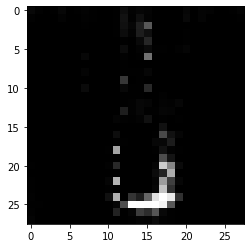



Time for epoch 6 is 25.986674070358276 sec
['gen_loss: 0.9287428855895996']
['disc_loss: 1.2251321077346802']
['gen_val_loss: 1.2437769174575806']
['disc_val_loss: 1.0596123933792114']


Time for epoch 7 is 26.177000522613525 sec
['gen_loss: 1.0548135042190552']
['disc_loss: 1.1311266422271729']
['gen_val_loss: 0.9447519183158875']
['disc_val_loss: 1.1540073156356812']


Time for epoch 8 is 26.24488615989685 sec
['gen_loss: 1.0496301651000977']
['disc_loss: 1.1395164728164673']
['gen_val_loss: 1.1888595819473267']
['disc_val_loss: 0.987143874168396']


Time for epoch 9 is 26.386345863342285 sec
['gen_loss: 1.06581449508667']
['disc_loss: 1.0829428434371948']
['gen_val_loss: 1.0493329763412476']
['disc_val_loss: 1.2018431425094604']


Time for epoch 10 is 26.14513397216797 sec
['gen_loss: 1.0886362791061401']
['disc_loss: 1.104262351989746']
['gen_val_loss: 1.139290690422058']
['disc_val_loss: 1.0859549045562744']
Picture from epoch 9 


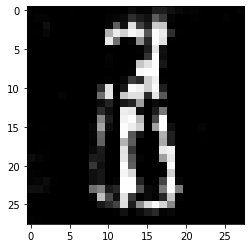

In [ ]:

# Define where to save the log
hyperparameter_string= "Your_Settings_Here"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"test_logs/{hyperparameter_string}/{current_time}/train"
val_log_path = f"test_logs/{hyperparameter_string}/{current_time}/val"
train_log_path = "test_logs/train"
val_log_path =  "test_logs/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)


# first download data if not done before
download_data()
category = 'candle'
# # images of candels 141545
# loading the dataset and split into train and test set
images = np.load(f'npy_files/{category}.npy')
print(f"Total num of images: {len(images)}")
train_images = images[:100000]
test_images = images[100000:140000]

# maybe a smaller dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images))
prepared_train_dataset = train_dataset.apply(prepare_dataset)
prepared_test_dataset = test_dataset.apply(prepare_dataset)
print(f"Shape of dataset: {prepared_test_dataset}")

generator = Generator(input_dim=NOISE_INPUT_DIM)
discriminator = Discriminator()
test_image_noise = tf.random.normal([1, NOISE_INPUT_DIM])

for epoch in range(EPOCHS):
    start = time.time()
    
    # Training:
    for image_batch in prepared_train_dataset:
        noise = tf.random.normal([BATCH_SIZE, NOISE_INPUT_DIM])
        gen_metrics, generated_images = generator.train_step(noise, discriminator)
        disc_metrics =  discriminator.train_step(image_batch, generated_images)

    # print the metrics
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    print([f"gen_{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])
    print([f"disc_{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    
    # logging the training metrics to the log file which is used by tensorboard
    with train_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"gen_{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"disc_{metric.name}", metric.result(), step=epoch)
    
    # reset all metrics (requires a reset_metrics method in the model)
    generator.reset_metrics()
    discriminator.reset_metrics()

    # Validation:

    for data in prepared_test_dataset:
        noise = tf.random.normal([BATCH_SIZE, NOISE_INPUT_DIM])
        gen_metrics, generated_images = generator.test_step(noise, discriminator)
        disc_metrics =  discriminator.test_step(image_batch, generated_images)
    
    print([f"gen_val_{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])
    print([f"disc_val_{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    
    # logging the validation metrics to the log file which is used by tensorboard
    with val_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"gen_val_{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"disc_val_{metric.name}", metric.result(), step=epoch)

        # every (5) epochs generate images for the test_image_noise and write it to tensorboard
        if (epoch+1)%5 == 0:
            generated_test_images = generator(test_image_noise, training=False)
            # save a batch of images for this epoch (have to be between 0 and 1)
            tf.summary.image(name="generated_images",data = generated_test_images, step=epoch, max_outputs=32)
            
            print("Picture from epoch {} ".format(epoch))
            plt.imshow(generated_images[0, :, :, 0], cmap='gray')
            plt.show()
    
    # reset all metrics
    generator.reset_metrics()
    discriminator.reset_metrics()   
     
    print("\n")
